## Loading Libraries

In [1]:
import os
import copy
import time
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [2]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchvision.io import read_image
torch.manual_seed(0)

## Data Loading

In [3]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        labels = []
        paths = []
        for file_name in os.listdir(img_dir):
            labels.append(int(file_name.split('_')[0]))
            paths.append(os.path.join(img_dir, file_name))
        
        self.img_labels = pd.DataFrame([paths, labels]).T
        del labels
        del paths

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label   

In [4]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, weights=None):
        self.dataset = dataset
        self.weights = np.array(weights)
        self.transform = dataset.transform
        self.target_transform = dataset.target_transform
        self.num_classes = len(self.dataset.img_labels[1].unique())
        
        if weights is None:
            self.weights = np.ones(self.num_classes, dtype=np.int8)
        if len(self.weights) != self.num_classes:
            raise ValueError("Expected {} weights. Provided {}. len(weights) should be equal to number of classes".
                             format(self.num_classes, len(self.weights)))

        labels = []
        paths = []
        df = self.dataset.img_labels
        for fpath, label in df.itertuples(index=False):
            for _ in range(self.weights[label]):
                paths.append(fpath)
                labels.append(label)
        
        self.img_labels = pd.DataFrame([paths, labels]).T

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1

# We are converting into RGB format as MobileNet expects 3 channel images.
data_transforms = {"train" : transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        weights.transforms()
    ]),
    "val" : transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        weights.transforms()
    ])
}

In [6]:
train_path = "train"
val_path = "val"

train_imgDataset = ImageDataset(img_dir=train_path, transform=data_transforms["train"])
valid_imgDataset = ImageDataset(img_dir=val_path, transform=data_transforms["val"])

In [7]:
train_imgDataset.img_labels[1].value_counts(sort=False)

1
0     200
1     313
2     669
3      70
4     675
5    3022
6      87
Name: count, dtype: int64

In [8]:
valid_imgDataset.img_labels[1].value_counts(sort=False)

1
0     127
1     201
2     430
3      45
4     438
5    2000
6      55
Name: count, dtype: int64

In [9]:
print(len(train_imgDataset), len(valid_imgDataset))

5036 3296


In [10]:
label_weights = [3,3,2,5,2,1,4]
train_dataset = AugmentedDataset(train_imgDataset, weights=label_weights)
valid_dataset = AugmentedDataset(valid_imgDataset)

In [11]:
print(len(train_dataset), len(valid_dataset))

7947 3296


In [12]:
train_dataset.img_labels[1].value_counts(sort=False)

1
0     600
1     939
2    1338
3     350
4    1350
5    3022
6     348
Name: count, dtype: int64

In [13]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
len(train_loader)

125

In [14]:
def imshow_(inp, title=None):
    inp = inp.permute(1, 2, 0).numpy()       # Permutes the dimensions of the image.
    inp = (inp - inp.min()) / (inp.max() - inp.min())
    print(inp.shape)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    # plt.pause(0.1)
    plt.show()

(224, 224, 3)


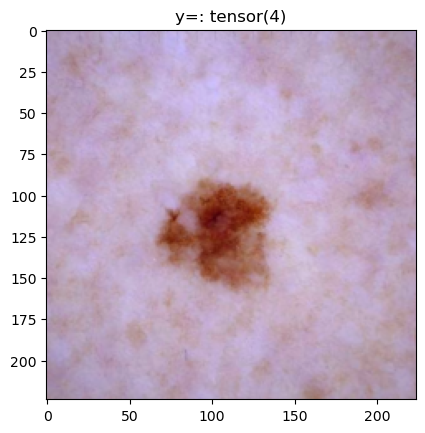

(224, 224, 3)


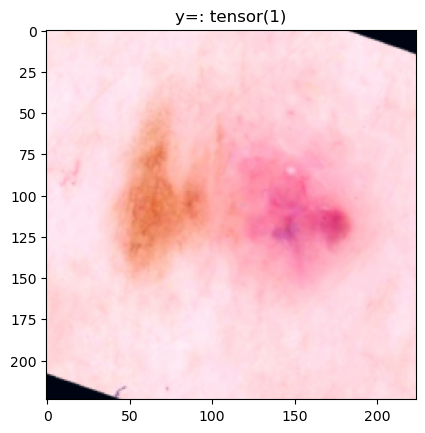

(224, 224, 3)


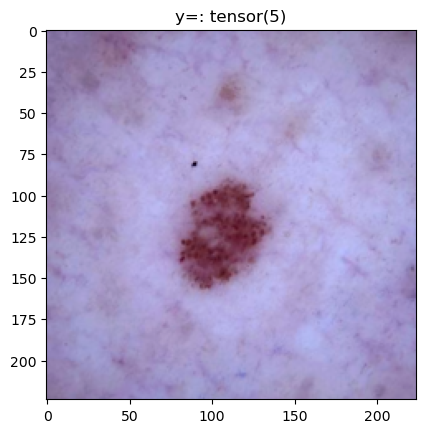

In [15]:
for x,y  in train_loader:
    for i in range(len(y)):
        imshow_(x[i],"y=: {}".format(str(y[i])))
        if i==2:
            break
    break

In [17]:
for x,y  in train_loader:
    for i in range(len(y)):
        print(x[i].shape)
        break
    break

torch.Size([3, 224, 224])


## Training Model 1

### Hyperparameters

In [16]:
n_epochs = 15
batch_size = 64
lr = 0.001
n_classes = 7
momentum = 0.9

In [17]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

In [18]:
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The device type is:", device)

The device type is: cpu


In [20]:
for param in model.parameters():
    param.requires_grad = False

In [21]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [22]:
model.features[12] = models.mobilenetv3.Conv2dNormActivation(
    in_channels = 96,
    out_channels = 512,
    kernel_size = 1,
    stride = 1,
    bias = False,
    activation_layer = lambda *args, **kwargs: nn.Hardswish()
)

model.classifier = nn.Sequential(
    nn.Linear(in_features=512, out_features=1024, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1024, out_features=n_classes, bias=True)
)

In [23]:
model = model.to(device)

In [24]:
class_weights = torch.Tensor(1/train_dataset.img_labels[1].value_counts(sort=False, normalize=True))
class_weights/class_weights.min()

tensor([5.0367, 3.2183, 2.2586, 8.6343, 2.2385, 1.0000, 8.6839])

In [25]:
class_weights = torch.Tensor([3, 2.5, 2, 5, 2, 1, 5])
class_weights = class_weights.to(device)
print(class_weights)

tensor([3.0000, 2.5000, 2.0000, 5.0000, 2.0000, 1.0000, 5.0000])


### Training only last layer

In [26]:
criterion1 = nn.CrossEntropyLoss(weight=class_weights)
"""
optimizer1 = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer1 = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=3, gamma=0.5)
scheduler1 = lr_scheduler.CyclicLR(optimizer1, base_lr=0.1, max_lr=0.3,step_size_up=5,mode="triangular2")
scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer1, mode='max', factor=0.5, patience=2)
"""
optimizer1 = torch.optim.Adam(model.parameters(), lr=lr)
scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=3, gamma=0.5)

In [27]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs, scheduler=None, print_=True):
    loss_list = []
    accuracy_list = []
    models_list = []
    correct = 0
    n_test = len(validation_loader.dataset)
    accuracy_best=0
    train_cost_best = 2
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
    for epoch in range(n_epochs):
        loss_sublist = []
        model.train()
        
        if print_:
            print(f"Learning rate for epoch {epoch+1}:", optimizer.param_groups[0]['lr'])
            
        # Loop through the data in loader
        for x, y in tqdm(train_loader):
            x, y=x.to(device), y.to(device)
            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_cost = np.mean(loss_sublist)
        loss_list.append(train_cost)
        
        correct = 0
        model.eval()
        print("Fetching validation results for epoch {} ...".format(epoch+1))

        with torch.no_grad():
            for x_test, y_test in validation_loader:
                x_test, y_test=x_test.to(device), y_test.to(device)
                z = model(x_test)
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y_test).sum().item()
            accuracy = correct / n_test
            accuracy_list.append(accuracy)
        
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(accuracy)
            else:
                scheduler.step()
        
        if accuracy>accuracy_best:
            accuracy_best = accuracy
            train_cost_best = train_cost
            best_model_wts = copy.deepcopy(model.state_dict())
        elif accuracy == accuracy_best and train_cost < train_cost_best:
            train_cost_best = train_cost
            best_model_wts = copy.deepcopy(model.state_dict())
      
        if print_:
            print("The training cost for epoch " + str(epoch + 1) + ": " + str(train_cost))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy))
            print()
        models_list.append(copy.deepcopy(model.state_dict()))
    model.load_state_dict(best_model_wts)
    return accuracy_list, loss_list, model, models_list

In [28]:
start_datetime = datetime.now()
start_time=time.time()
print("Training started at:", datetime.now())

accuracy_list,loss_list, model, mod_list = train_model(model,train_loader , valid_loader, criterion1, optimizer1, scheduler=scheduler1, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("Elapsed time", elapsed_time )

Training started at: 2025-05-30 15:31:31.226679
Learning rate for epoch 1: 0.001


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [03:03<00:00,  1.47s/it]


Fetching validation results for epoch 1 ...
The training cost for epoch 1: 1.242268241405487
The validation accuracy for epoch 1: 0.6067961165048543

Learning rate for epoch 2: 0.001


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:26<00:00,  1.17s/it]


Fetching validation results for epoch 2 ...
The training cost for epoch 2: 1.016852306842804
The validation accuracy for epoch 2: 0.6768810679611651

Learning rate for epoch 3: 0.001


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:21<00:00,  1.13s/it]


Fetching validation results for epoch 3 ...
The training cost for epoch 3: 0.9393313579559326
The validation accuracy for epoch 3: 0.6620145631067961

Learning rate for epoch 4: 0.0005


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:23<00:00,  1.15s/it]


Fetching validation results for epoch 4 ...
The training cost for epoch 4: 0.8787155079841614
The validation accuracy for epoch 4: 0.6699029126213593

Learning rate for epoch 5: 0.0005


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:22<00:00,  1.14s/it]


Fetching validation results for epoch 5 ...
The training cost for epoch 5: 0.8370824494361877
The validation accuracy for epoch 5: 0.6844660194174758

Learning rate for epoch 6: 0.0005


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:24<00:00,  1.15s/it]


Fetching validation results for epoch 6 ...
The training cost for epoch 6: 0.8166283702850342
The validation accuracy for epoch 6: 0.6635315533980582

Learning rate for epoch 7: 0.00025


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:22<00:00,  1.14s/it]


Fetching validation results for epoch 7 ...
The training cost for epoch 7: 0.7878905844688415
The validation accuracy for epoch 7: 0.6932645631067961

Learning rate for epoch 8: 0.00025


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:21<00:00,  1.13s/it]


Fetching validation results for epoch 8 ...
The training cost for epoch 8: 0.755525472164154
The validation accuracy for epoch 8: 0.6787014563106796

Learning rate for epoch 9: 0.00025


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:21<00:00,  1.13s/it]


Fetching validation results for epoch 9 ...
The training cost for epoch 9: 0.744303430557251
The validation accuracy for epoch 9: 0.6987257281553398

Learning rate for epoch 10: 0.000125


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:20<00:00,  1.12s/it]


Fetching validation results for epoch 10 ...
The training cost for epoch 10: 0.7337402131557464
The validation accuracy for epoch 10: 0.7014563106796117

Learning rate for epoch 11: 0.000125


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:19<00:00,  1.12s/it]


Fetching validation results for epoch 11 ...
The training cost for epoch 11: 0.7287479708194733
The validation accuracy for epoch 11: 0.693871359223301

Learning rate for epoch 12: 0.000125


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:20<00:00,  1.12s/it]


Fetching validation results for epoch 12 ...
The training cost for epoch 12: 0.7269153537750244
The validation accuracy for epoch 12: 0.6838592233009708

Learning rate for epoch 13: 6.25e-05


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:25<00:00,  1.16s/it]


Fetching validation results for epoch 13 ...
The training cost for epoch 13: 0.6924802658557891
The validation accuracy for epoch 13: 0.6920509708737864

Learning rate for epoch 14: 6.25e-05


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:21<00:00,  1.13s/it]


Fetching validation results for epoch 14 ...
The training cost for epoch 14: 0.7010834257602692
The validation accuracy for epoch 14: 0.689623786407767

Learning rate for epoch 15: 6.25e-05


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [02:21<00:00,  1.13s/it]


Fetching validation results for epoch 15 ...
The training cost for epoch 15: 0.7137323958873749
The validation accuracy for epoch 15: 0.6932645631067961

Elapsed time 2599.333029985428


In [29]:
def evaluate(model, dataloader, class_names, title):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

    # Compute classification metrics
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    tot_acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    print("\nClassification Report:")
    print(f"Total accuracy: {tot_acc}\n")
    print(pd.DataFrame([class_accuracy, precision, recall, f1], columns=class_names, index=["Accuracy", "Precision", "Recall", "F1-Score"]).T)

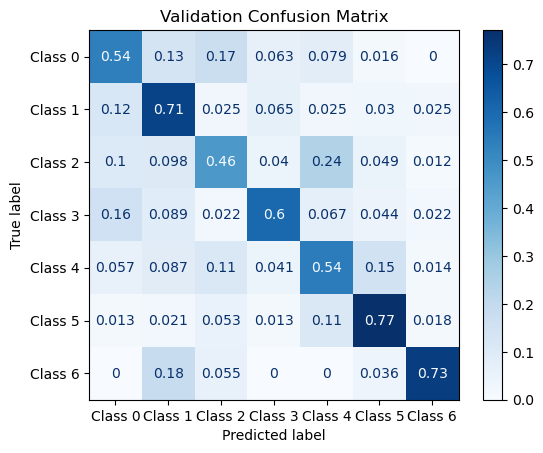


Classification Report:
Total accuracy: 0.6844660194174758

         Accuracy  Precision    Recall  F1-Score
Class 0  0.535433   0.350515  0.535433  0.423676
Class 1  0.711443   0.481481  0.711443  0.574297
Class 2  0.458140   0.515707  0.458140  0.485222
Class 3  0.600000   0.250000  0.600000  0.352941
Class 4  0.543379   0.408935  0.543379  0.466667
Class 5  0.771500   0.940280  0.771500  0.847569
Class 6  0.727273   0.434783  0.727273  0.544218


In [38]:
model.load_state_dict(mod_list[4])
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, valid_loader, class_names, title="Validation Confusion Matrix")

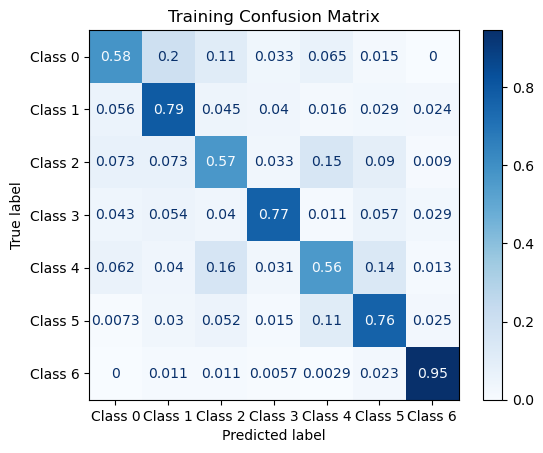


Classification Report:
Total accuracy: 0.6919592298980748

         Accuracy  Precision    Recall  F1-Score
Class 0  0.580000   0.561290  0.580000  0.570492
Class 1  0.789137   0.659253  0.789137  0.718371
Class 2  0.568012   0.605096  0.568012  0.585968
Class 3  0.765714   0.585153  0.765714  0.663366
Class 4  0.558519   0.557280  0.558519  0.557899
Class 5  0.760754   0.861049  0.760754  0.807800
Class 6  0.945402   0.706009  0.945402  0.808354


In [39]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, train_loader, class_names, title="Training Confusion Matrix")

In [40]:
torch.save(model.state_dict(), "modstage2/model_small_1_684.pt")

## Fine Tuning

In [41]:
# model.load_state_dict(torch.load("modstage2/model_small_1_706.pt", weights_only = True))
for param in model.parameters():
    param.requires_grad = True

In [42]:
class_weights = torch.Tensor(1/train_dataset.img_labels[1].value_counts(sort=False, normalize=True))
class_weights/class_weights.min()

tensor([5.0367, 3.2183, 2.2586, 8.6343, 2.2385, 1.0000, 8.6839])

In [43]:
class_weights = torch.Tensor([3, 2.5, 2, 4, 2, 1, 4])
class_weights = class_weights.to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

In [44]:
criterion2 = nn.CrossEntropyLoss(weight=class_weights)
optimizer2 = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer2 = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=2, gamma=0.5)

start_datetime = datetime.now()
start_time=time.time()
print("Training started at:", datetime.now())

accuracy_list2,loss_list2, model, mod_list2 = train_model(model,train_loader , valid_loader, criterion2, optimizer2, scheduler=scheduler2, n_epochs=6)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("Elapsed time", elapsed_time )

Training started at: 2025-05-30 17:53:02.580917
Learning rate for epoch 1: 0.001


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [03:45<00:00,  1.80s/it]


Fetching validation results for epoch 1 ...
The training cost for epoch 1: 0.7870747015476227
The validation accuracy for epoch 1: 0.6501820388349514

Learning rate for epoch 2: 0.001


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [04:01<00:00,  1.93s/it]


Fetching validation results for epoch 2 ...
The training cost for epoch 2: 0.578729413986206
The validation accuracy for epoch 2: 0.7496966019417476

Learning rate for epoch 3: 0.0005


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [03:55<00:00,  1.88s/it]


Fetching validation results for epoch 3 ...
The training cost for epoch 3: 0.3720860197544098
The validation accuracy for epoch 3: 0.7754854368932039

Learning rate for epoch 4: 0.0005


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [03:50<00:00,  1.84s/it]


Fetching validation results for epoch 4 ...
The training cost for epoch 4: 0.29282954275608064
The validation accuracy for epoch 4: 0.7715412621359223

Learning rate for epoch 5: 0.00025


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [03:50<00:00,  1.85s/it]


Fetching validation results for epoch 5 ...
The training cost for epoch 5: 0.19788809621334075
The validation accuracy for epoch 5: 0.8115898058252428

Learning rate for epoch 6: 0.00025


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [03:49<00:00,  1.84s/it]


Fetching validation results for epoch 6 ...
The training cost for epoch 6: 0.1753234923481941
The validation accuracy for epoch 6: 0.7864077669902912

Elapsed time 1557.0444550514221


In [45]:
model.load_state_dict(mod_list2[-2])

<All keys matched successfully>

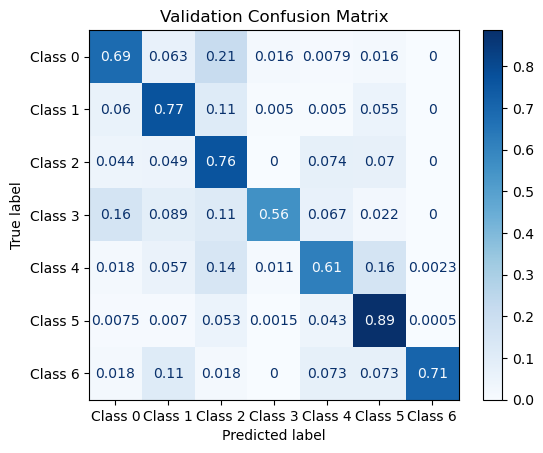


Classification Report:
Total accuracy: 0.8115898058252428

         Accuracy  Precision    Recall  F1-Score
Class 0  0.685039   0.583893  0.685039  0.630435
Class 1  0.766169   0.663793  0.766169  0.711316
Class 2  0.762791   0.595281  0.762791  0.668705
Class 3  0.555556   0.694444  0.555556  0.617284
Class 4  0.614155   0.677582  0.614155  0.644311
Class 5  0.886500   0.938095  0.886500  0.911568
Class 6  0.709091   0.951220  0.709091  0.812500


In [46]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, valid_loader, class_names, title="Validation Confusion Matrix")

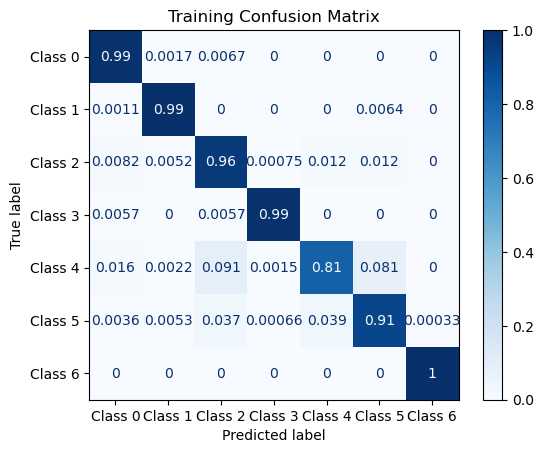


Classification Report:
Total accuracy: 0.9266389832641249

         Accuracy  Precision    Recall  F1-Score
Class 0  0.991667   0.928237  0.991667  0.958904
Class 1  0.992545   0.971846  0.992545  0.982086
Class 2  0.961883   0.842829  0.961883  0.898429
Class 3  0.988571   0.985755  0.988571  0.987161
Class 4  0.808889   0.891429  0.808889  0.848155
Class 5  0.914626   0.954750  0.914626  0.934257
Class 6  1.000000   0.997135  1.000000  0.998565


In [47]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, train_loader, class_names, title="Training Confusion Matrix")

In [48]:
torch.save(model.state_dict(), "modstage2/model_small_2_812.pt")

Best Model: modstage2/model_small_2_812.pt